In [68]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import re
import os

In [69]:
def alpha(Tgas):
    invsqrtT = 1e0 / np.sqrt(Tgas)
    return 3.0 * 1e-6 * invsqrtT # 1/s

def beta(Tgas):
    return 3.0 * 1e-9  # 1/s

def gamma(Tgas):
    invsqrtT = 1e0 / np.sqrt(Tgas)
    return 3.0 * 1e-11 * invsqrtT # 1/s

def zeta(Tgas):
    return 1e-17 # 1/s

def zetaX(r,dSigma):
    zeta0 = 2.6e-15 # s^-1
    Sigma_stop = 8 # g/cm^2
    AU = 1.496e+13 # cm
    
    return zeta0 * r**(-2) * np.exp(-dSigma/Sigma_stop)

def zetaCR(dSigma):
    zeta0 = 1e-17 # s^-1
    Sigma_stop = 100 # g/cm^2
    AU = 1.496e+13 # cm
    
    return zeta0 * np.exp(-dSigma/Sigma_stop)

def zeta_ion(Rcyl,Zcyl,rho,plot=False):
    aux_Rcyl = np.copy(Rcyl)
    aux_Zcyl = np.copy(Zcyl)

    AU = 1.496e+13 # cm

    dz = aux_Zcyl[:-1,:] - aux_Zcyl[1:,:] # cm

    dSigma = rho[1:,:] * dz # g/cm^2

    delta_Sigma = np.zeros_like(rho)
    delta_Sigma[1:,:] = np.cumsum(dSigma, axis=0) # g/cm^2

    zeta_X = zetaX(aux_Rcyl/AU, delta_Sigma)
    zeta_CR = zetaCR(delta_Sigma)
    zeta_tot = zeta_X + zeta_CR

    return zeta_tot

def cubic_func(ne,nM,nm,Tgas,zeta):
    return ne**3 + ((beta(Tgas)*nM/alpha(Tgas))*ne**2) - ((zeta*nm/alpha(Tgas))*ne) - (zeta*nm*beta(Tgas)*nM/alpha(Tgas)/gamma(Tgas))

def Xe_func(nm,Tgas,zeta):
    return np.sqrt(zeta/alpha(Tgas)/nm)

def ne_func(nm,nM,Tgas,zeta):
    return ((zeta * nm * beta(Tgas) * nM)/(alpha(Tgas) * gamma(Tgas)))**(1/3)

def convergence(path,rtol=1e-16, plot=False):
    ne_0    = np.load(f"{path}/e_000.npy")
    nm_0    = np.load(f"{path}/m_000.npy")
    nmp_0   = np.load(f"{path}/mp_000.npy")
    nM_0    = np.load(f"{path}/M_000.npy")
    nMp_0   = np.load(f"{path}/Mp_000.npy")
    Xe_n    = ne_0/nm_0
    snap_i  = 0

    # Get all .npy files
    files = glob.glob(f"{path}/*.npy")

    # Extract indices regardless of prefix
    snap_max = max([int(re.search(r'_(\d+)\.npy$', f).group(1)) for f in files if re.search(r'_(\d+)\.npy$', f)])

    while snap_i < snap_max:
        snap_i += 1

        ne  = np.load(f"{path}/e_{snap_i:03}.npy")
        nm  = np.load(f"{path}/m_{snap_i:03}.npy")
        nmp = np.load(f"{path}/mp_{snap_i:03}.npy")
        nM  = np.load(f"{path}/M_{snap_i:03}.npy")
        nMp = np.load(f"{path}/Mp_{snap_i:03}.npy")

        Xe_np1 = ne/nm

        diff = np.abs(Xe_n - Xe_np1)/Xe_n
        Xe_n = Xe_np1
        if np.mean(diff) < rtol:
            orb = snap_max/10
            print(f"The solution converges at snap = {snap_i/orb} orbit(s)")
            break
    
    if plot:
        max_nm = []
        max_nmp = []
        max_ne = []
        max_nM = []
        max_nMp = []
        max_xe = []

        for snapshot in range(0, snap_max+1, 1):
            ne = np.load(f"{path}/e_{snapshot:03}.npy")
            nm = np.load(f"{path}/m_{snapshot:03}.npy")
            nmp = np.load(f"{path}/mp_{snapshot:03}.npy")
            nM = np.load(f"{path}/M_{snapshot:03}.npy")
            nMp = np.load(f"{path}/Mp_{snapshot:03}.npy")
            xe = ne/nm

            max_nm.append(np.max(nm))
            max_nmp.append(np.max(nmp))
            max_ne.append(np.max(ne))
            max_nM.append(np.max(nM))
            max_nMp.append(np.max(nMp))
            max_xe.append(np.max(xe))

        # plt.plot(max_nm, label=f"nm {snapshot}")
        # plt.plot(max_nmp, label=f"nmp {snapshot}")
        # plt.plot(max_ne, label=f"ne {snapshot}")
        # plt.plot(max_nM, label=f"nM {snapshot}")
        # plt.plot(max_nMp, label=f"nMp {snapshot}")
        plt.plot(max_xe, label=f"Xe {snapshot}")
        plt.loglog()
        plt.show()
    return snap_i


In [70]:
AU = 1.496e+13 #cm
mu = 2.33
mH = 1.67e-24 # g
me = 9.11e-28 # g

In [71]:
path = "disk/"
rho_iso  = np.load(path+"dens_iso.npy")
rho_rt   = np.load(path+"dens_rt.npy")
rho_gap  = np.load(path+"dens_gap.npy")
T_iso    = np.load(path+"T_iso.npy")
T_rt     = np.load(path+"T_rt.npy")
T_gap    = np.load(path+"T_gap.npy")
Rcyl     = np.load(path+"Rcyl.npy")
Zcyl     = np.load(path+"Zcyl.npy")
ntot_iso = rho_iso/(mu*mH)
ntot_rt  = rho_rt/(mu*mH)
ntot_gap = rho_gap/(mu*mH)

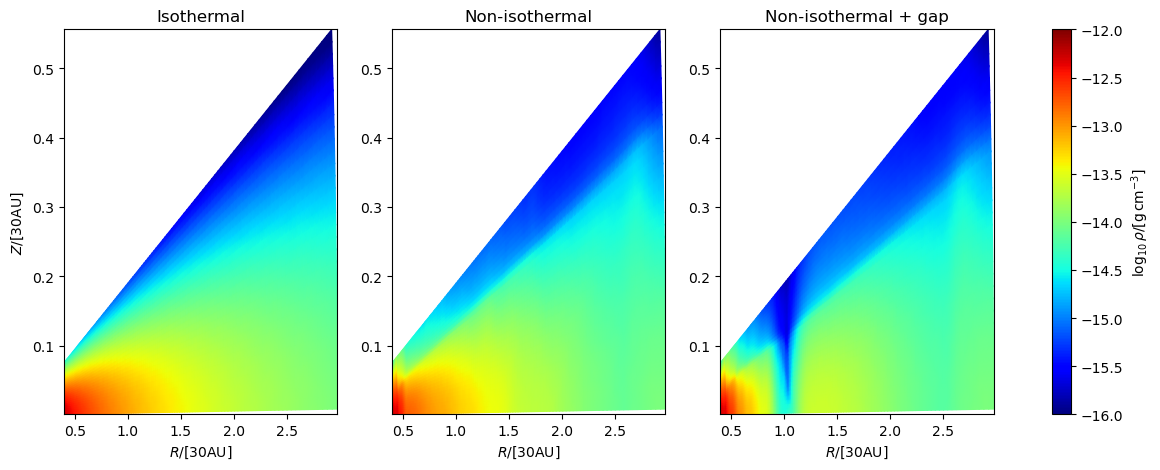

In [72]:
cmap  ="jet"
vmin  = -16
vmax  = -12

fig = plt.figure(figsize=(15,5))

ax1 = fig.add_subplot(131)
ax1.set_title(r"Isothermal")
im1 = plt.pcolormesh(Rcyl/(30*AU), Zcyl/(30*AU), np.log10(rho_iso), shading="gouraud", cmap = cmap, vmin=vmin, vmax=vmax)
plt.ylabel(r"$Z/[30{\rm AU}]$")
plt.xlabel(r"$R/[30{\rm AU}]$")

ax2 = fig.add_subplot(132)
ax2.set_title(r"Non-isothermal")
im2 = plt.pcolormesh(Rcyl/(30*AU), Zcyl/(30*AU), np.log10(rho_rt), shading="gouraud", cmap = cmap, vmin=vmin, vmax=vmax)
plt.xlabel(r"$R/[30{\rm AU}]$")

ax3 = fig.add_subplot(133)
ax3.set_title(r"Non-isothermal + gap")
im3 = plt.pcolormesh(Rcyl/(30*AU), Zcyl/(30*AU), np.log10(rho_gap), shading="gouraud", cmap = cmap, vmin=vmin, vmax=vmax)
plt.xlabel(r"$R/[30{\rm AU}]$")

cbar = fig.colorbar(im1, ax=[ax1, ax2, ax3], location='right')
cbar.set_label(r"$\log_{10}{\rho/[{\rm g}\,{\rm cm}^{-3}]}$")

plt.savefig("figures/disk_models.pdf", format="pdf", dpi=300, bbox_inches='tight')
plt.show()

# Isothermal Distribution

In [73]:
# Set case variables
T        = T_iso
rho      = rho_iso
ntot     = ntot_iso
invsqrtT = 1e0 / np.sqrt(T)

# Fixed parameters
zeta  = zeta_ion(Rcyl, Zcyl, rho)   # Ionization rate

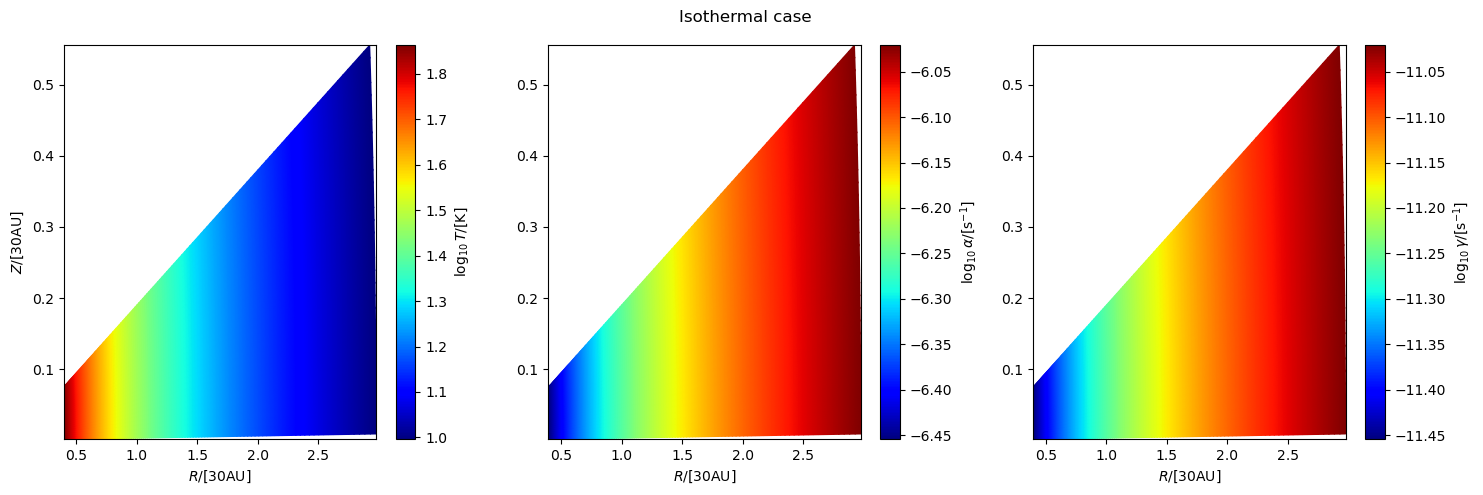

In [74]:
fig = plt.figure(figsize=(15,5))
fig.add_subplot(131)
fig.suptitle(r"Isothermal case")
im1 = plt.pcolormesh(Rcyl/(30*AU),Zcyl/(30*AU),np.log10(T),cmap='jet',shading='gouraud')
plt.xlabel(r"$R/[30{\rm AU}]$")
plt.ylabel(r"$Z/[30{\rm AU}]$")
plt.colorbar(im1,label=r"$\log_{10}{T/[{\rm K}]}$")
fig.add_subplot(132)
im2 = plt.pcolormesh(Rcyl/(30*AU),Zcyl/(30*AU),np.log10(alpha(T)),cmap='jet',shading='gouraud')
plt.xlabel(r"$R/[30{\rm AU}]$")
plt.colorbar(im2,label=r"$\log_{10}{\alpha/[{\rm s}^{-1}]}$")
fig.add_subplot(133)
im3 = plt.pcolormesh(Rcyl/(30*AU),Zcyl/(30*AU),np.log10(gamma(T)),cmap='jet',shading='gouraud')
plt.xlabel(r"$R/[30{\rm AU}]$")
plt.colorbar(im3,label=r"$\log_{10}{\gamma/[{\rm s}^{-1}]}$")
plt.tight_layout()
plt.show()

### $X_M=0$

In [75]:
spath = "M_0_iso"
snap_i = convergence(spath,rtol=1e-16)

The solution converges at snap = 0.12 orbit(s)


In [76]:
ne  = np.load(f"{spath}/e_{snap_i:03}.npy")
nm  = np.load(f"{spath}/m_{snap_i:03}.npy")
nmp = np.load(f"{spath}/mp_{snap_i:03}.npy")
nM  = np.load(f"{spath}/M_{snap_i:03}.npy")
nMp = np.load(f"{spath}/Mp_{snap_i:03}.npy")

zeta = zeta_ion(Rcyl,Zcyl,rho)
cubic = cubic_func(ne,nM,nm,T,zeta)
Xe = Xe_func(nm,T,zeta)

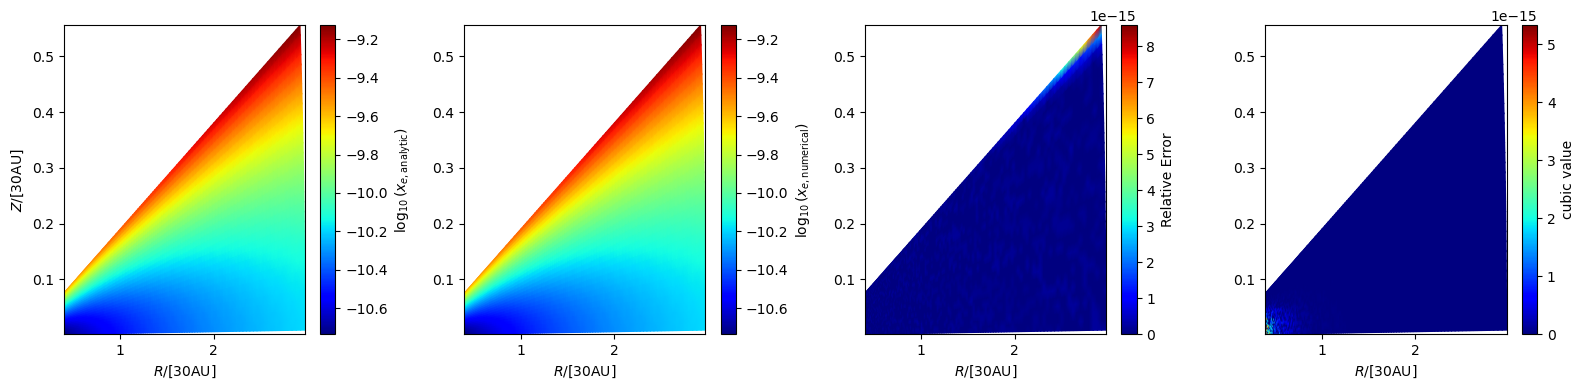

In [77]:
fig = plt.figure(figsize=(16,4))

fig.add_subplot(141)
im1 = plt.pcolormesh(Rcyl/(30*AU),Zcyl/(30*AU),np.log10(Xe),cmap='jet',shading='gouraud')
plt.xlabel(r"$R/[30{\rm AU}]$")
plt.ylabel(r"$Z/[30{\rm AU}]$")
plt.colorbar(im1, label=r'$\log_{10}(x_{e,{\rm analytic}})$')

fig.add_subplot(142)
im2 = plt.pcolormesh(Rcyl/(30*AU),Zcyl/(30*AU),np.log10(ne/nm),cmap='jet',shading='gouraud')
plt.xlabel(r"$R/[30{\rm AU}]$")
plt.colorbar(im2, label=r'$\log_{10}(x_{e,{\rm numerical}})$')

fig.add_subplot(143)
im3 = plt.pcolormesh(Rcyl/(30*AU),Zcyl/(30*AU),(np.abs((ne/nm)- Xe))/Xe,cmap='jet',shading='gouraud')
plt.xlabel(r"$R/[30{\rm AU}]$")
plt.colorbar(im3, label="Relative Error")

fig.add_subplot(144)
im4 = plt.pcolormesh(Rcyl/(30*AU),Zcyl/(30*AU),np.abs(cubic),cmap='jet',shading='gouraud')
plt.colorbar(im4, label="cubic value")
plt.xlabel(r"$R/[30{\rm AU}]$")

plt.tight_layout()
plt.show()

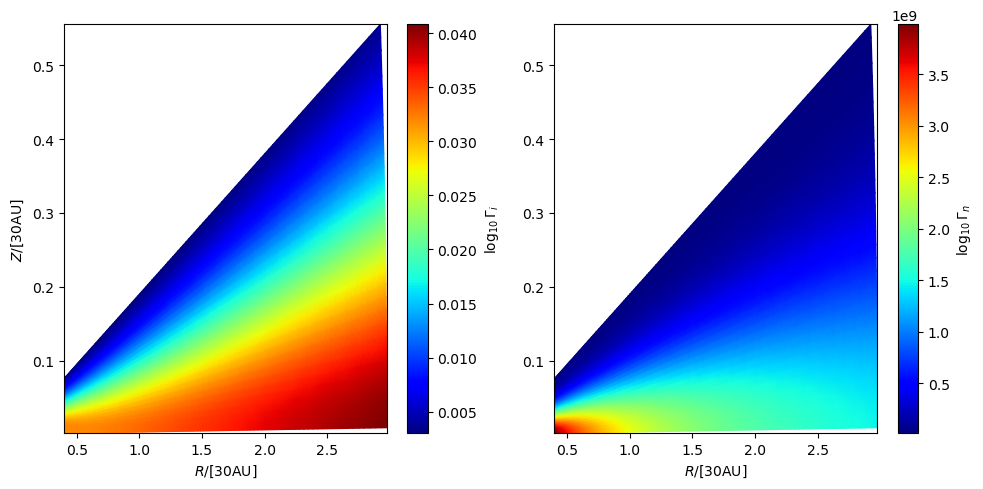

In [78]:
mn = 2.33 * mH
mnp = 1 * mH
mM = 30 * mH
mMp = 30 * mH
G = 6.674e-8 # dyn cm**2 g**-2
Mstar = 1.989e+33 # g
Omega = np.sqrt(G * Mstar / (Rcyl**3))
gamma_T = 3.5*1e+13 # cm**3 s**-1 g**-1

rho_m = nm * mn
rho_mp = nmp * mnp
rho_M = nM * mM
rho_Mp = nMp * mMp

rho_n = rho_m + rho_M
rho_i = rho_mp + rho_Mp

ions = gamma_T * rho_i / Omega
neutrals = gamma_T * rho_n / Omega

fig = plt.figure(figsize=(10,5))
fig.add_subplot(121)
im1 = plt.pcolormesh(Rcyl/(30*AU),Zcyl/(30*AU),ions,cmap='jet',shading='gouraud')
plt.xlabel(r"$R/[30{\rm AU}]$")
plt.ylabel(r"$Z/[30{\rm AU}]$")
plt.colorbar(im1, label=r"$\log_{10}{\Gamma_{i}}$")
fig.add_subplot(122)
im2 = plt.pcolormesh(Rcyl/(30*AU),Zcyl/(30*AU),neutrals,cmap='jet',shading='gouraud')
plt.xlabel(r"$R/[30{\rm AU}]$")
plt.colorbar(im2, label=r"$\log_{10}{\Gamma_{n}}$")

plt.tight_layout()
plt.show()

### $X_{\rm M}=10^{-13}$

In [79]:
spath = "xM-13_iso"
snap_i = convergence(spath)

The solution converges at snap = 0.01 orbit(s)


In [80]:
ne  = np.load(f"{spath}/e_{snap_i:03}.npy")
nm  = np.load(f"{spath}/m_{snap_i:03}.npy")
nmp = np.load(f"{spath}/mp_{snap_i:03}.npy")
nM  = np.load(f"{spath}/M_{snap_i:03}.npy")
nMp = np.load(f"{spath}/Mp_{snap_i:03}.npy")

zeta = zeta_ion(Rcyl,Zcyl,rho)
cubic = cubic_func(ne,nM,nm,T,zeta)
Xe = Xe_func(nm,T,zeta)

# in principle the analitical value of Xe is calculated in the first snapshot as one root of the cubic, then...
ne_0 = np.load(f"{spath}/e_000.npy")
nm_0 = np.load(f"{spath}/m_000.npy")
Xe_0 = ne_0/nm_0

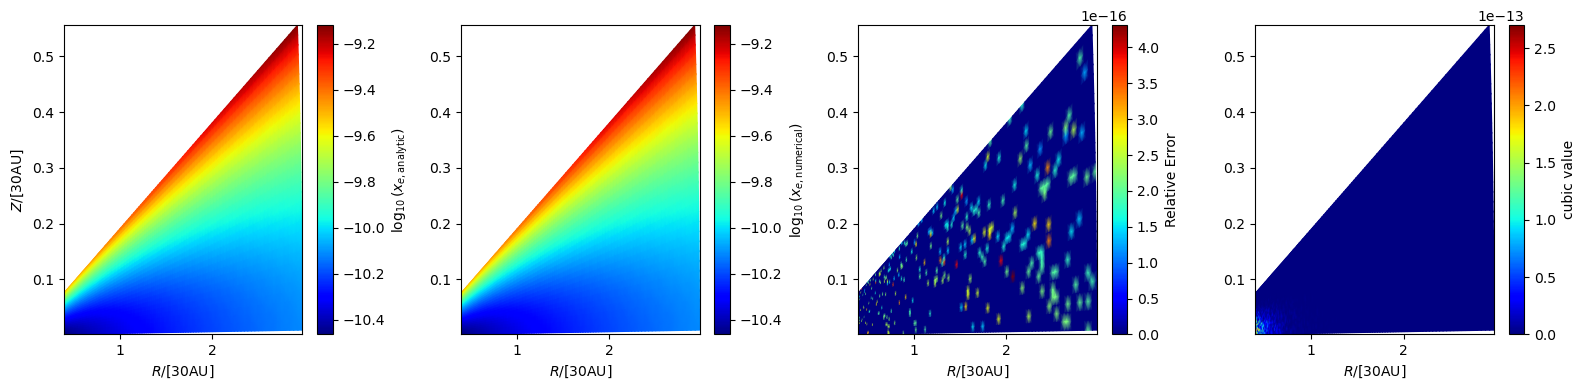

In [81]:
fig = plt.figure(figsize=(16,4))

fig.add_subplot(141)
im1 = plt.pcolormesh(Rcyl/(30*AU),Zcyl/(30*AU),np.log10(Xe_0),cmap='jet',shading='gouraud')
plt.xlabel(r"$R/[30{\rm AU}]$")
plt.ylabel(r"$Z/[30{\rm AU}]$")
plt.colorbar(im1, label=r'$\log_{10}(x_{e,{\rm analytic}})$')

fig.add_subplot(142)
im2 = plt.pcolormesh(Rcyl/(30*AU),Zcyl/(30*AU),np.log10(ne/nm),cmap='jet',shading='gouraud')
plt.xlabel(r"$R/[30{\rm AU}]$")
plt.colorbar(im2, label=r'$\log_{10}(x_{e,{\rm numerical}})$')

fig.add_subplot(143)
im3 = plt.pcolormesh(Rcyl/(30*AU),Zcyl/(30*AU),(np.abs((ne/nm)- Xe_0))/Xe,cmap='jet',shading='gouraud')
plt.xlabel(r"$R/[30{\rm AU}]$")
plt.colorbar(im3, label="Relative Error")

fig.add_subplot(144)
im4 = plt.pcolormesh(Rcyl/(30*AU),Zcyl/(30*AU),np.abs(cubic),cmap='jet',shading='gouraud')
plt.colorbar(im4, label="cubic value")
plt.xlabel(r"$R/[30{\rm AU}]$")

plt.tight_layout()
plt.show()

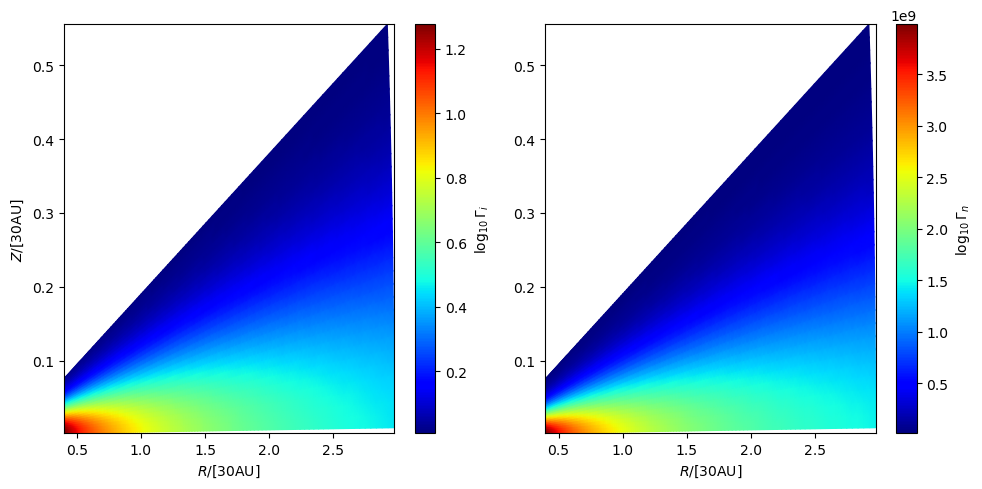

In [82]:
mn = 2.33 * mH
mnp = 1 * mH
mM = 30 * mH
mMp = 30 * mH
G = 6.674e-8 # dyn cm**2 g**-2
Mstar = 1.989e+33 # g
Omega = np.sqrt(G * Mstar / (Rcyl**3))
gamma_T = 3.5*1e+13 # cm**3 s**-1 g**-1

rho_m = nm * mn
rho_mp = nmp * mnp
rho_M = nM * mM
rho_Mp = nMp * mMp

rho_n = rho_m + rho_M
rho_i = rho_mp + rho_Mp

ions = gamma_T * rho_i / Omega
neutrals = gamma_T * rho_n / Omega

fig = plt.figure(figsize=(10,5))
fig.add_subplot(121)
im1 = plt.pcolormesh(Rcyl/(30*AU),Zcyl/(30*AU),ions,cmap='jet',shading='gouraud')
plt.xlabel(r"$R/[30{\rm AU}]$")
plt.ylabel(r"$Z/[30{\rm AU}]$")
plt.colorbar(im1, label=r"$\log_{10}{\Gamma_{i}}$")
fig.add_subplot(122)
im2 = plt.pcolormesh(Rcyl/(30*AU),Zcyl/(30*AU),neutrals,cmap='jet',shading='gouraud')
plt.xlabel(r"$R/[30{\rm AU}]$")
plt.colorbar(im2, label=r"$\log_{10}{\Gamma_{n}}$")

plt.tight_layout()
plt.show()

### $X_{\rm M}=10^{-12}$

In [83]:
spath = "xM-12_iso"
snap_i = convergence(spath)

The solution converges at snap = 0.01 orbit(s)


In [84]:
ne  = np.load(f"{spath}/e_{snap_i:03}.npy")
nm  = np.load(f"{spath}/m_{snap_i:03}.npy")
nmp = np.load(f"{spath}/mp_{snap_i:03}.npy")
nM  = np.load(f"{spath}/M_{snap_i:03}.npy")
nMp = np.load(f"{spath}/Mp_{snap_i:03}.npy")

zeta = zeta_ion(Rcyl,Zcyl,rho)
cubic = cubic_func(ne,nM,nm,T,zeta)
Xe = Xe_func(nm,T,zeta)

# in principle the analitical value of Xe is calculated in the first snapshot as one root of the cubic, then...
ne_0 = np.load(f"{spath}/e_000.npy")
nm_0 = np.load(f"{spath}/m_000.npy")
Xe_0 = ne_0/nm_0

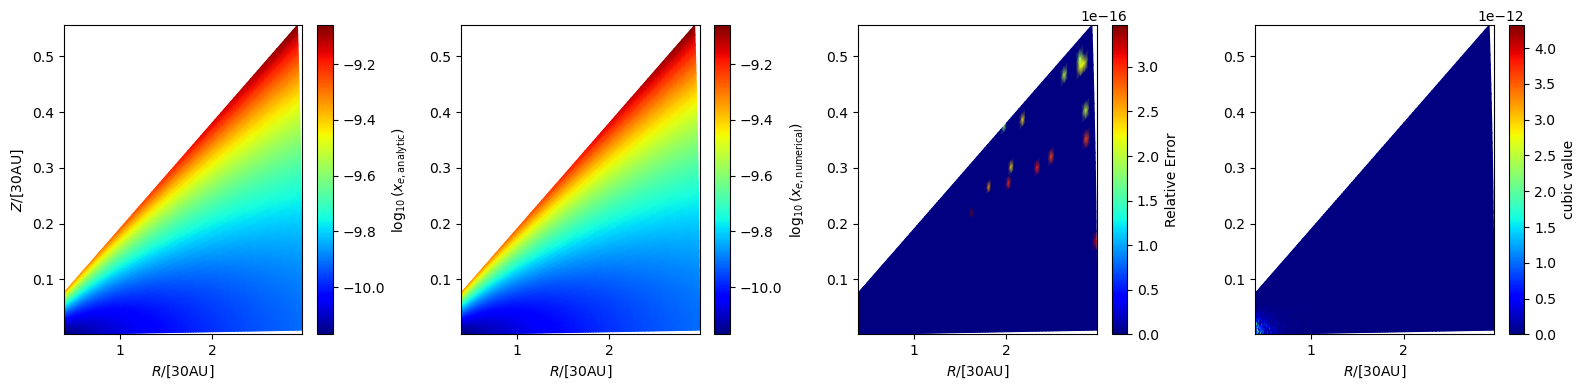

In [85]:
fig = plt.figure(figsize=(16,4))

fig.add_subplot(141)
im1 = plt.pcolormesh(Rcyl/(30*AU),Zcyl/(30*AU),np.log10(Xe_0),cmap='jet',shading='gouraud')
plt.xlabel(r"$R/[30{\rm AU}]$")
plt.ylabel(r"$Z/[30{\rm AU}]$")
plt.colorbar(im1, label=r'$\log_{10}(x_{e,{\rm analytic}})$')

fig.add_subplot(142)
im2 = plt.pcolormesh(Rcyl/(30*AU),Zcyl/(30*AU),np.log10(ne/nm),cmap='jet',shading='gouraud')
plt.xlabel(r"$R/[30{\rm AU}]$")
plt.colorbar(im2, label=r'$\log_{10}(x_{e,{\rm numerical}})$')

fig.add_subplot(143)
im3 = plt.pcolormesh(Rcyl/(30*AU),Zcyl/(30*AU),(np.abs((ne/nm)- Xe_0))/Xe,cmap='jet',shading='gouraud')
plt.xlabel(r"$R/[30{\rm AU}]$")
plt.colorbar(im3, label="Relative Error")

fig.add_subplot(144)
im4 = plt.pcolormesh(Rcyl/(30*AU),Zcyl/(30*AU),np.abs(cubic),cmap='jet',shading='gouraud')
plt.colorbar(im4, label="cubic value")
plt.xlabel(r"$R/[30{\rm AU}]$")

plt.tight_layout()
plt.show()

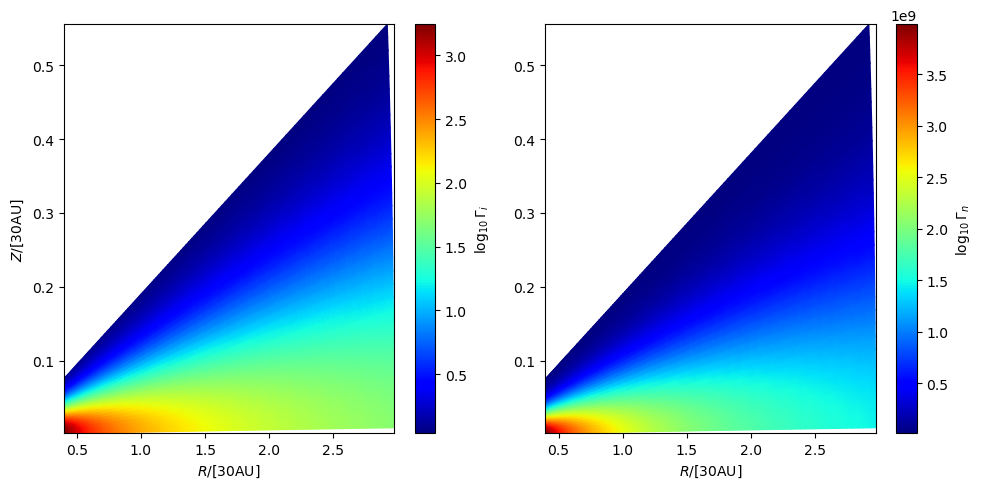

In [86]:
mn = 2.33 * mH
mnp = 1 * mH
mM = 30 * mH
mMp = 30 * mH
G = 6.674e-8 # dyn cm**2 g**-2
Mstar = 1.989e+33 # g
Omega = np.sqrt(G * Mstar / (Rcyl**3))
gamma_T = 3.5*1e+13 # cm**3 s**-1 g**-1

rho_m = nm * mn
rho_mp = nmp * mnp
rho_M = nM * mM
rho_Mp = nMp * mMp

rho_n = rho_m + rho_M
rho_i = rho_mp + rho_Mp

ions = gamma_T * rho_i / Omega
neutrals = gamma_T * rho_n / Omega

fig = plt.figure(figsize=(10,5))
fig.add_subplot(121)
im1 = plt.pcolormesh(Rcyl/(30*AU),Zcyl/(30*AU),ions,cmap='jet',shading='gouraud')
plt.xlabel(r"$R/[30{\rm AU}]$")
plt.ylabel(r"$Z/[30{\rm AU}]$")
plt.colorbar(im1, label=r"$\log_{10}{\Gamma_{i}}$")
fig.add_subplot(122)
im2 = plt.pcolormesh(Rcyl/(30*AU),Zcyl/(30*AU),neutrals,cmap='jet',shading='gouraud')
plt.xlabel(r"$R/[30{\rm AU}]$")
plt.colorbar(im2, label=r"$\log_{10}{\Gamma_{n}}$")

plt.tight_layout()
plt.show()

# Non-isothermal Distribution

In [87]:
# Set case variables
T        = T_rt
rho      = rho_rt
ntot     = ntot_rt
invsqrtT = 1e0 / np.sqrt(T)

# Fixed parameters
zeta  = zeta_ion(Rcyl, Zcyl, rho)   # Ionization rate

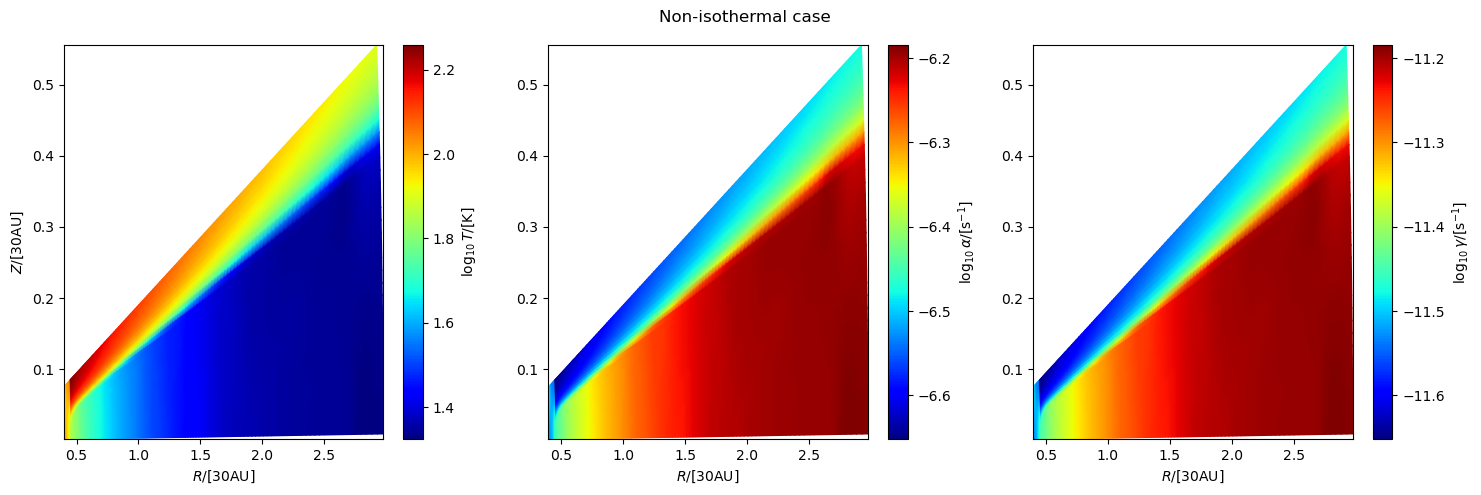

In [88]:
fig = plt.figure(figsize=(15,5))
fig.add_subplot(131)
fig.suptitle(r"Non-isothermal case")
im1 = plt.pcolormesh(Rcyl/(30*AU),Zcyl/(30*AU),np.log10(T),cmap='jet',shading='gouraud')
plt.xlabel(r"$R/[30{\rm AU}]$")
plt.ylabel(r"$Z/[30{\rm AU}]$")
plt.colorbar(im1,label=r"$\log_{10}{T/[{\rm K}]}$")
fig.add_subplot(132)
im2 = plt.pcolormesh(Rcyl/(30*AU),Zcyl/(30*AU),np.log10(alpha(T)),cmap='jet',shading='gouraud')
plt.xlabel(r"$R/[30{\rm AU}]$")
plt.colorbar(im2,label=r"$\log_{10}{\alpha/[{\rm s}^{-1}]}$")
fig.add_subplot(133)
im3 = plt.pcolormesh(Rcyl/(30*AU),Zcyl/(30*AU),np.log10(gamma(T)),cmap='jet',shading='gouraud')
plt.xlabel(r"$R/[30{\rm AU}]$")
plt.colorbar(im3,label=r"$\log_{10}{\gamma/[{\rm s}^{-1}]}$")
plt.tight_layout()
plt.show()

### $X_M=0$

In [89]:
spath = "M_0_noniso"
snap_i = convergence(spath,rtol=1e-16)

The solution converges at snap = 0.13 orbit(s)


In [90]:
ne  = np.load(f"{spath}/e_{snap_i:03}.npy")
nm  = np.load(f"{spath}/m_{snap_i:03}.npy")
nmp = np.load(f"{spath}/mp_{snap_i:03}.npy")
nM  = np.load(f"{spath}/M_{snap_i:03}.npy")
nMp = np.load(f"{spath}/Mp_{snap_i:03}.npy")

zeta = zeta_ion(Rcyl,Zcyl,rho)
cubic = cubic_func(ne,nM,nm,T,zeta)
Xe = Xe_func(nm,T,zeta)

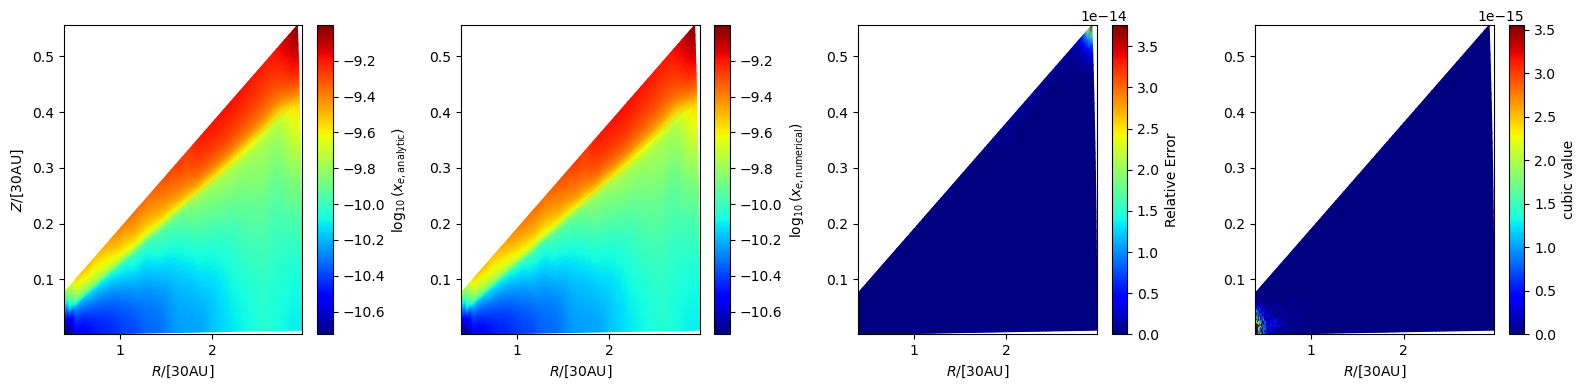

In [91]:
fig = plt.figure(figsize=(16,4))

fig.add_subplot(141)
im1 = plt.pcolormesh(Rcyl/(30*AU),Zcyl/(30*AU),np.log10(Xe),cmap='jet',shading='gouraud')
plt.xlabel(r"$R/[30{\rm AU}]$")
plt.ylabel(r"$Z/[30{\rm AU}]$")
plt.colorbar(im1, label=r'$\log_{10}(x_{e,{\rm analytic}})$')

fig.add_subplot(142)
im2 = plt.pcolormesh(Rcyl/(30*AU),Zcyl/(30*AU),np.log10(ne/nm),cmap='jet',shading='gouraud')
plt.xlabel(r"$R/[30{\rm AU}]$")
plt.colorbar(im2, label=r'$\log_{10}(x_{e,{\rm numerical}})$')

fig.add_subplot(143)
im3 = plt.pcolormesh(Rcyl/(30*AU),Zcyl/(30*AU),(np.abs((ne/nm)- Xe))/Xe,cmap='jet',shading='gouraud')
plt.xlabel(r"$R/[30{\rm AU}]$")
plt.colorbar(im3, label="Relative Error")

fig.add_subplot(144)
im4 = plt.pcolormesh(Rcyl/(30*AU),Zcyl/(30*AU),np.abs(cubic),cmap='jet',shading='gouraud')
plt.colorbar(im4, label="cubic value")
plt.xlabel(r"$R/[30{\rm AU}]$")

plt.tight_layout()
plt.show()

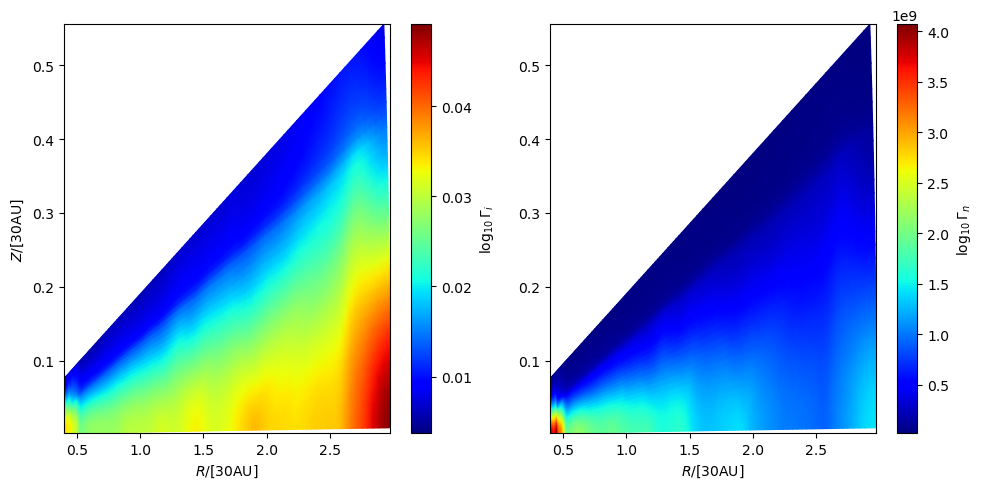

In [92]:
mn = 2.33 * mH
mnp = 1 * mH
mM = 30 * mH
mMp = 30 * mH
G = 6.674e-8 # dyn cm**2 g**-2
Mstar = 1.989e+33 # g
Omega = np.sqrt(G * Mstar / (Rcyl**3))
gamma_T = 3.5*1e+13 # cm**3 s**-1 g**-1

rho_m = nm * mn
rho_mp = nmp * mnp
rho_M = nM * mM
rho_Mp = nMp * mMp

rho_n = rho_m + rho_M
rho_i = rho_mp + rho_Mp

ions = gamma_T * rho_i / Omega
neutrals = gamma_T * rho_n / Omega

fig = plt.figure(figsize=(10,5))
fig.add_subplot(121)
im1 = plt.pcolormesh(Rcyl/(30*AU),Zcyl/(30*AU),ions,cmap='jet',shading='gouraud')
plt.xlabel(r"$R/[30{\rm AU}]$")
plt.ylabel(r"$Z/[30{\rm AU}]$")
plt.colorbar(im1, label=r"$\log_{10}{\Gamma_{i}}$")
fig.add_subplot(122)
im2 = plt.pcolormesh(Rcyl/(30*AU),Zcyl/(30*AU),neutrals,cmap='jet',shading='gouraud')
plt.xlabel(r"$R/[30{\rm AU}]$")
plt.colorbar(im2, label=r"$\log_{10}{\Gamma_{n}}$")

plt.tight_layout()
plt.show()

### $X_{\rm M} = 10^{-13}$

In [93]:
spath = "xM-13_noniso"
snap_i = convergence(spath)

The solution converges at snap = 0.01 orbit(s)


In [94]:
ne  = np.load(f"{spath}/e_{snap_i:03}.npy")
nm  = np.load(f"{spath}/m_{snap_i:03}.npy")
nmp = np.load(f"{spath}/mp_{snap_i:03}.npy")
nM  = np.load(f"{spath}/M_{snap_i:03}.npy")
nMp = np.load(f"{spath}/Mp_{snap_i:03}.npy")

zeta = zeta_ion(Rcyl,Zcyl,rho)
cubic = cubic_func(ne,nM,nm,T,zeta)
Xe = Xe_func(nm,T,zeta)

# in principle the analitical value of Xe is calculated in the first snapshot as one root of the cubic, then...
ne_0 = np.load(f"{spath}/e_000.npy")
nm_0 = np.load(f"{spath}/m_000.npy")
Xe_0 = ne_0/nm_0

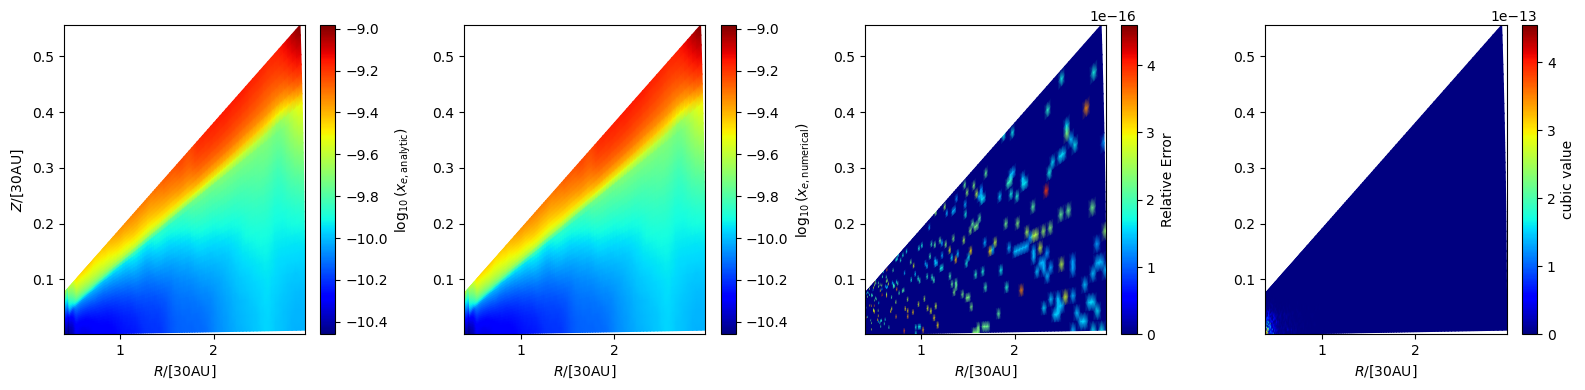

In [95]:
fig = plt.figure(figsize=(16,4))

fig.add_subplot(141)
im1 = plt.pcolormesh(Rcyl/(30*AU),Zcyl/(30*AU),np.log10(Xe_0),cmap='jet',shading='gouraud')
plt.xlabel(r"$R/[30{\rm AU}]$")
plt.ylabel(r"$Z/[30{\rm AU}]$")
plt.colorbar(im1, label=r'$\log_{10}(x_{e,{\rm analytic}})$')

fig.add_subplot(142)
im2 = plt.pcolormesh(Rcyl/(30*AU),Zcyl/(30*AU),np.log10(ne/nm),cmap='jet',shading='gouraud')
plt.xlabel(r"$R/[30{\rm AU}]$")
plt.colorbar(im2, label=r'$\log_{10}(x_{e,{\rm numerical}})$')

fig.add_subplot(143)
im3 = plt.pcolormesh(Rcyl/(30*AU),Zcyl/(30*AU),(np.abs((ne/nm)- Xe_0))/Xe,cmap='jet',shading='gouraud')
plt.xlabel(r"$R/[30{\rm AU}]$")
plt.colorbar(im3, label="Relative Error")

fig.add_subplot(144)
im4 = plt.pcolormesh(Rcyl/(30*AU),Zcyl/(30*AU),np.abs(cubic),cmap='jet',shading='gouraud')
plt.colorbar(im4, label="cubic value")
plt.xlabel(r"$R/[30{\rm AU}]$")

plt.tight_layout()
plt.show()

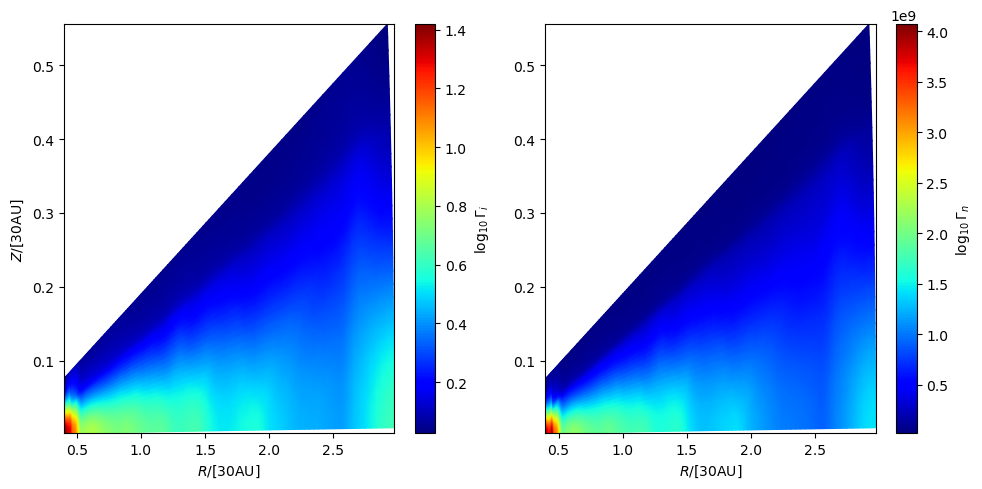

In [96]:
mn = 2.33 * mH
mnp = 1 * mH
mM = 30 * mH
mMp = 30 * mH
G = 6.674e-8 # dyn cm**2 g**-2
Mstar = 1.989e+33 # g
Omega = np.sqrt(G * Mstar / (Rcyl**3))
gamma_T = 3.5*1e+13 # cm**3 s**-1 g**-1

rho_m = nm * mn
rho_mp = nmp * mnp
rho_M = nM * mM
rho_Mp = nMp * mMp

rho_n = rho_m + rho_M
rho_i = rho_mp + rho_Mp

ions = gamma_T * rho_i / Omega
neutrals = gamma_T * rho_n / Omega

fig = plt.figure(figsize=(10,5))
fig.add_subplot(121)
im1 = plt.pcolormesh(Rcyl/(30*AU),Zcyl/(30*AU),ions,cmap='jet',shading='gouraud')
plt.xlabel(r"$R/[30{\rm AU}]$")
plt.ylabel(r"$Z/[30{\rm AU}]$")
plt.colorbar(im1, label=r"$\log_{10}{\Gamma_{i}}$")
fig.add_subplot(122)
im2 = plt.pcolormesh(Rcyl/(30*AU),Zcyl/(30*AU),neutrals,cmap='jet',shading='gouraud')
plt.xlabel(r"$R/[30{\rm AU}]$")
plt.colorbar(im2, label=r"$\log_{10}{\Gamma_{n}}$")

plt.tight_layout()
plt.show()

### $X_{\rm M} = 10^{-12}$

In [97]:
spath = "xM-12_noniso"
snap_i = convergence(spath)

The solution converges at snap = 0.01 orbit(s)


In [98]:
ne  = np.load(f"{spath}/e_{snap_i:03}.npy")
nm  = np.load(f"{spath}/m_{snap_i:03}.npy")
nmp = np.load(f"{spath}/mp_{snap_i:03}.npy")
nM  = np.load(f"{spath}/M_{snap_i:03}.npy")
nMp = np.load(f"{spath}/Mp_{snap_i:03}.npy")

zeta = zeta_ion(Rcyl,Zcyl,rho)
cubic = cubic_func(ne,nM,nm,T,zeta)
Xe = Xe_func(nm,T,zeta)

# in principle the analitical value of Xe is calculated in the first snapshot as one root of the cubic, then...
ne_0 = np.load(f"{spath}/e_000.npy")
nm_0 = np.load(f"{spath}/m_000.npy")
Xe_0 = ne_0/nm_0

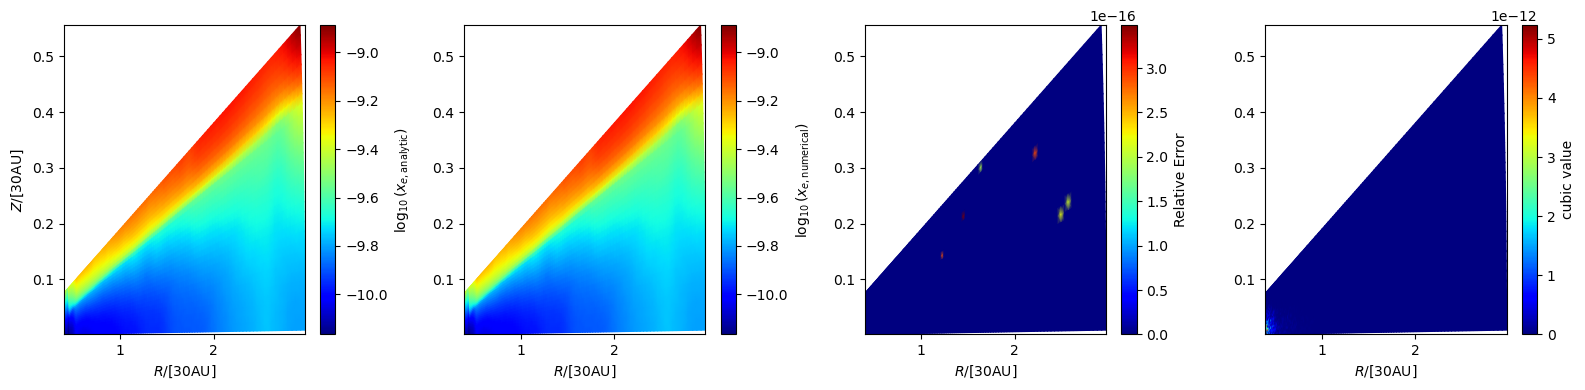

In [99]:
fig = plt.figure(figsize=(16,4))

fig.add_subplot(141)
im1 = plt.pcolormesh(Rcyl/(30*AU),Zcyl/(30*AU),np.log10(Xe_0),cmap='jet',shading='gouraud')
plt.xlabel(r"$R/[30{\rm AU}]$")
plt.ylabel(r"$Z/[30{\rm AU}]$")
plt.colorbar(im1, label=r'$\log_{10}(x_{e,{\rm analytic}})$')

fig.add_subplot(142)
im2 = plt.pcolormesh(Rcyl/(30*AU),Zcyl/(30*AU),np.log10(ne/nm),cmap='jet',shading='gouraud')
plt.xlabel(r"$R/[30{\rm AU}]$")
plt.colorbar(im2, label=r'$\log_{10}(x_{e,{\rm numerical}})$')

fig.add_subplot(143)
im3 = plt.pcolormesh(Rcyl/(30*AU),Zcyl/(30*AU),(np.abs((ne/nm)- Xe_0))/Xe,cmap='jet',shading='gouraud')
plt.xlabel(r"$R/[30{\rm AU}]$")
plt.colorbar(im3, label="Relative Error")

fig.add_subplot(144)
im4 = plt.pcolormesh(Rcyl/(30*AU),Zcyl/(30*AU),np.abs(cubic),cmap='jet',shading='gouraud')
plt.colorbar(im4, label="cubic value")
plt.xlabel(r"$R/[30{\rm AU}]$")

plt.tight_layout()
plt.show()

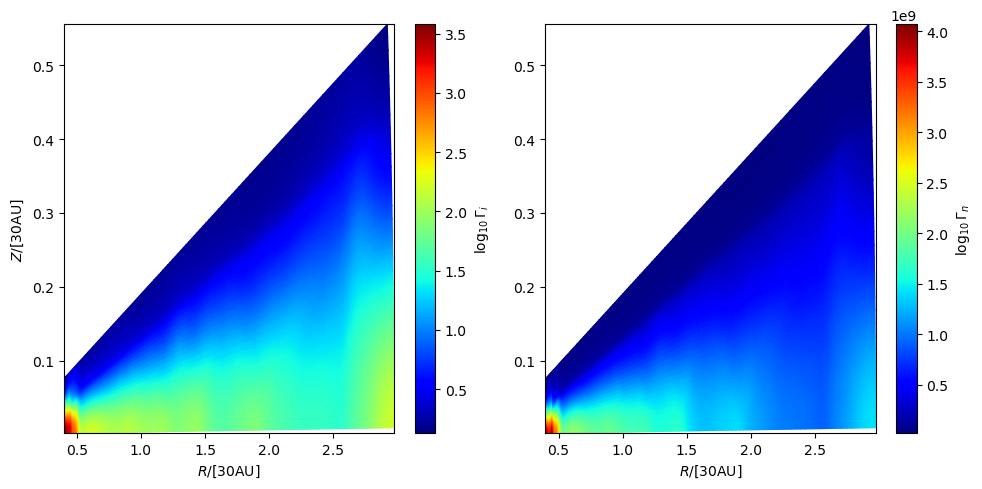

In [100]:
mn = 2.33 * mH
mnp = 1 * mH
mM = 30 * mH
mMp = 30 * mH
G = 6.674e-8 # dyn cm**2 g**-2
Mstar = 1.989e+33 # g
Omega = np.sqrt(G * Mstar / (Rcyl**3))
gamma_T = 3.5*1e+13 # cm**3 s**-1 g**-1

rho_m = nm * mn
rho_mp = nmp * mnp
rho_M = nM * mM
rho_Mp = nMp * mMp

rho_n = rho_m + rho_M
rho_i = rho_mp + rho_Mp

ions = gamma_T * rho_i / Omega
neutrals = gamma_T * rho_n / Omega

fig = plt.figure(figsize=(10,5))
fig.add_subplot(121)
im1 = plt.pcolormesh(Rcyl/(30*AU),Zcyl/(30*AU),ions,cmap='jet',shading='gouraud')
plt.xlabel(r"$R/[30{\rm AU}]$")
plt.ylabel(r"$Z/[30{\rm AU}]$")
plt.colorbar(im1, label=r"$\log_{10}{\Gamma_{i}}$")
fig.add_subplot(122)
im2 = plt.pcolormesh(Rcyl/(30*AU),Zcyl/(30*AU),neutrals,cmap='jet',shading='gouraud')
plt.xlabel(r"$R/[30{\rm AU}]$")
plt.colorbar(im2, label=r"$\log_{10}{\Gamma_{n}}$")

plt.tight_layout()
plt.show()

# Gap distribution

In [101]:
# Set case variables
T        = T_gap
rho      = rho_gap
ntot     = ntot_gap
invsqrtT = 1e0 / np.sqrt(T)

# Fixed parameters
zeta  = zeta_ion(Rcyl, Zcyl, rho)   # Ionization rate
cubic = cubic_func(ne,nM,nm,T,zeta)
Xe = Xe_func(nm,T,zeta)

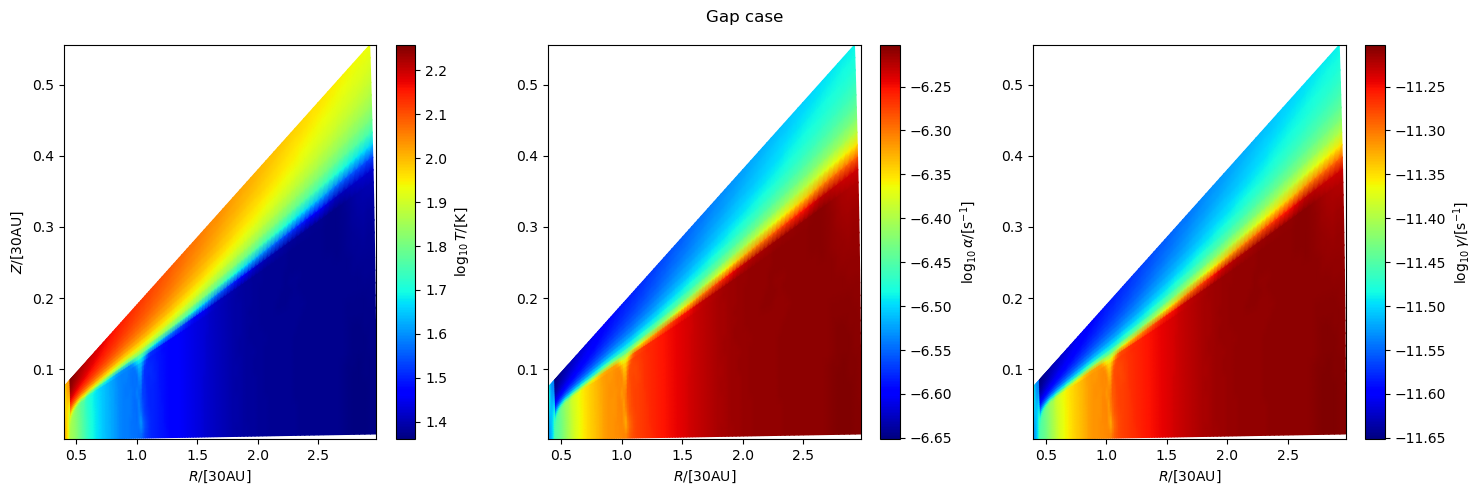

In [102]:
fig = plt.figure(figsize=(15,5))
fig.add_subplot(131)
fig.suptitle(r"Gap case")
im1 = plt.pcolormesh(Rcyl/(30*AU),Zcyl/(30*AU),np.log10(T),cmap='jet',shading='gouraud')
plt.xlabel(r"$R/[30{\rm AU}]$")
plt.ylabel(r"$Z/[30{\rm AU}]$")
plt.colorbar(im1,label=r"$\log_{10}{T/[{\rm K}]}$")
fig.add_subplot(132)
im2 = plt.pcolormesh(Rcyl/(30*AU),Zcyl/(30*AU),np.log10(alpha(T)),cmap='jet',shading='gouraud')
plt.xlabel(r"$R/[30{\rm AU}]$")
plt.colorbar(im2,label=r"$\log_{10}{\alpha/[{\rm s}^{-1}]}$")
fig.add_subplot(133)
im3 = plt.pcolormesh(Rcyl/(30*AU),Zcyl/(30*AU),np.log10(gamma(T)),cmap='jet',shading='gouraud')
plt.xlabel(r"$R/[30{\rm AU}]$")
plt.colorbar(im3,label=r"$\log_{10}{\gamma/[{\rm s}^{-1}]}$")
plt.tight_layout()
plt.show()

(32, 128)


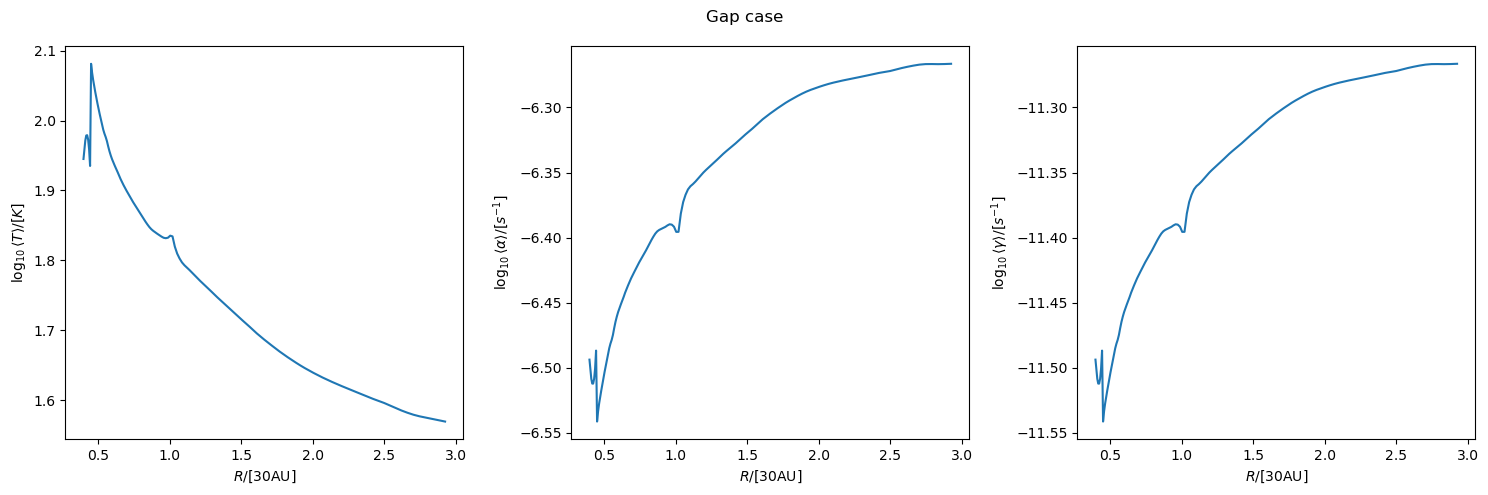

In [103]:
# Radial profiles

fig = plt.figure(figsize=(15,5))
fig.suptitle(r"Gap case")

print(T.shape)

fig.add_subplot(131)
T_avr = np.mean(T, axis=0)
im1 = plt.plot(Rcyl[0,:]/(30*AU),np.log10(T_avr),label=r"$\log_{10}{T/[{\rm K}]}$")
plt.xlabel(r"$R/[30{\rm AU}]$")
plt.ylabel(r"$\log_{10}\langle T \rangle/[K]$")

fig.add_subplot(132)
alpha_avr = np.mean(alpha(T), axis=0)
im2 = plt.plot(Rcyl[0,:]/(30*AU),np.log10(alpha_avr),label=r"$\log_{10}{\alpha/[{\rm s}^{-1}]}$")
plt.xlabel(r"$R/[30{\rm AU}]$")
plt.ylabel(r"$\log_{10}\langle \alpha \rangle/[s^{-1}]$")

fig.add_subplot(133)
gamma_avr = np.mean(gamma(T), axis=0)
im3 = plt.plot(Rcyl[0,:]/(30*AU),np.log10(gamma_avr),label=r"$\log_{10}{\gamma/[{\rm s}^{-1}]}$")
plt.xlabel(r"$R/[30{\rm AU}]$")
plt.ylabel(r"$\log_{10}\langle \gamma \rangle/[s^{-1}]$")

plt.tight_layout()
plt.show()

### $X_{M} = 0$

In [104]:
spath = "M_0_gap"
snap_i = convergence(spath,rtol=1e-16)

The solution converges at snap = 0.15 orbit(s)


In [105]:
ne  = np.load(f"{spath}/e_{snap_i:03}.npy")
nm  = np.load(f"{spath}/m_{snap_i:03}.npy")
nmp = np.load(f"{spath}/mp_{snap_i:03}.npy")
nM  = np.load(f"{spath}/M_{snap_i:03}.npy")
nMp = np.load(f"{spath}/Mp_{snap_i:03}.npy")

zeta = zeta_ion(Rcyl,Zcyl,rho)
cubic = cubic_func(ne,nM,nm,T,zeta)
Xe = Xe_func(nm,T,zeta)

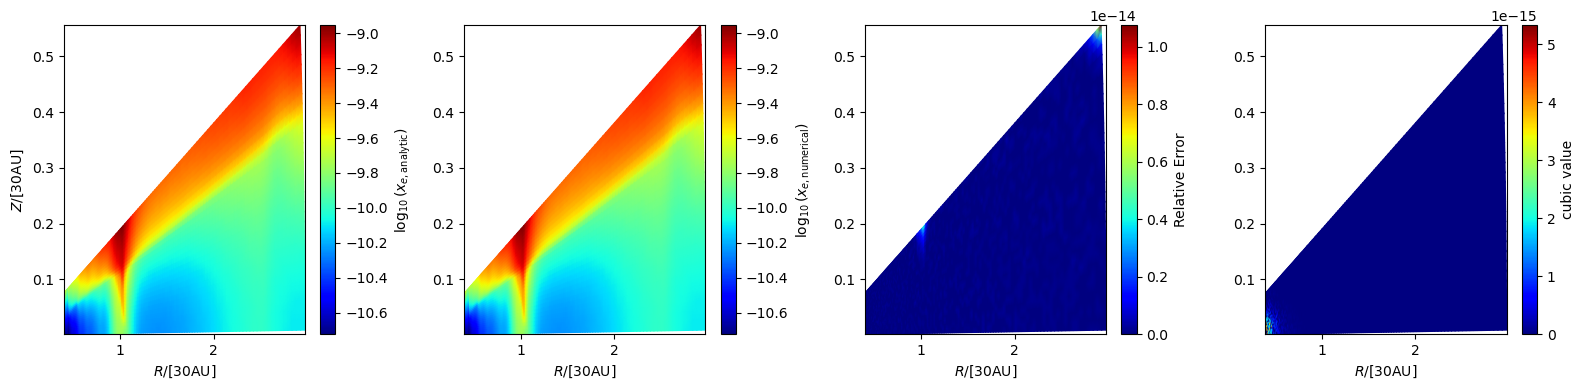

In [106]:
fig = plt.figure(figsize=(16,4))

fig.add_subplot(141)
im1 = plt.pcolormesh(Rcyl/(30*AU),Zcyl/(30*AU),np.log10(Xe),cmap='jet',shading='gouraud')
plt.xlabel(r"$R/[30{\rm AU}]$")
plt.ylabel(r"$Z/[30{\rm AU}]$")
plt.colorbar(im1, label=r'$\log_{10}(x_{e,{\rm analytic}})$')

fig.add_subplot(142)
im2 = plt.pcolormesh(Rcyl/(30*AU),Zcyl/(30*AU),np.log10(ne/nm),cmap='jet',shading='gouraud')
plt.xlabel(r"$R/[30{\rm AU}]$")
plt.colorbar(im2, label=r'$\log_{10}(x_{e,{\rm numerical}})$')

fig.add_subplot(143)
im3 = plt.pcolormesh(Rcyl/(30*AU),Zcyl/(30*AU),(np.abs((ne/nm)- Xe))/Xe,cmap='jet',shading='gouraud')
plt.xlabel(r"$R/[30{\rm AU}]$")
plt.colorbar(im3, label="Relative Error")

fig.add_subplot(144)
im4 = plt.pcolormesh(Rcyl/(30*AU),Zcyl/(30*AU),np.abs(cubic),cmap='jet',shading='gouraud')
plt.colorbar(im4, label="cubic value")
plt.xlabel(r"$R/[30{\rm AU}]$")

plt.tight_layout()
plt.show()

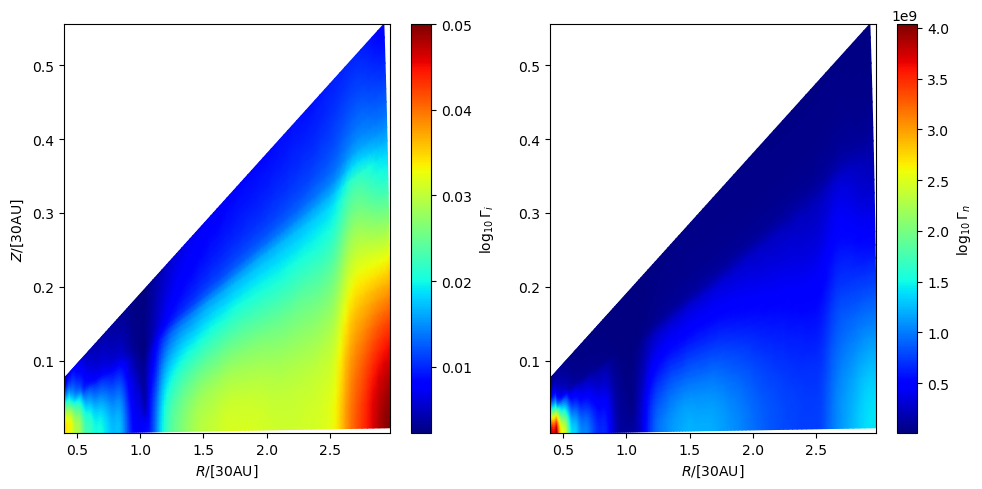

In [107]:
mn = 2.33 * mH
mnp = 1 * mH
mM = 30 * mH
mMp = 30 * mH
G = 6.674e-8 # dyn cm**2 g**-2
Mstar = 1.989e+33 # g
Omega = np.sqrt(G * Mstar / (Rcyl**3))
gamma_T = 3.5*1e+13 # cm**3 s**-1 g**-1

rho_m = nm * mn
rho_mp = nmp * mnp
rho_M = nM * mM
rho_Mp = nMp * mMp

rho_n = rho_m + rho_M
rho_i = rho_mp + rho_Mp

ions = gamma_T * rho_i / Omega
neutrals = gamma_T * rho_n / Omega

fig = plt.figure(figsize=(10,5))
fig.add_subplot(121)
im1 = plt.pcolormesh(Rcyl/(30*AU),Zcyl/(30*AU),ions,cmap='jet',shading='gouraud')
plt.xlabel(r"$R/[30{\rm AU}]$")
plt.ylabel(r"$Z/[30{\rm AU}]$")
plt.colorbar(im1, label=r"$\log_{10}{\Gamma_{i}}$")
fig.add_subplot(122)
im2 = plt.pcolormesh(Rcyl/(30*AU),Zcyl/(30*AU),neutrals,cmap='jet',shading='gouraud')
plt.xlabel(r"$R/[30{\rm AU}]$")
plt.colorbar(im2, label=r"$\log_{10}{\Gamma_{n}}$")

plt.tight_layout()
plt.show()

### $X_{M} = 10^{-12}$

In [108]:
spath = "xM-12_gap"
snap_i = convergence(spath)

The solution converges at snap = 0.01 orbit(s)


In [109]:
ne  = np.load(f"{spath}/e_{snap_i:03}.npy")
nm  = np.load(f"{spath}/m_{snap_i:03}.npy")
nmp = np.load(f"{spath}/mp_{snap_i:03}.npy")
nM  = np.load(f"{spath}/M_{snap_i:03}.npy")
nMp = np.load(f"{spath}/Mp_{snap_i:03}.npy")

zeta = zeta_ion(Rcyl,Zcyl,rho)
cubic = cubic_func(ne,nM,nm,T,zeta)
Xe = Xe_func(nm,T,zeta)

# in principle the analitical value of Xe is calculated in the first snapshot as one root of the cubic, then...
ne_0 = np.load(f"{spath}/e_000.npy")
nm_0 = np.load(f"{spath}/m_000.npy")
Xe_0 = ne_0/nm_0

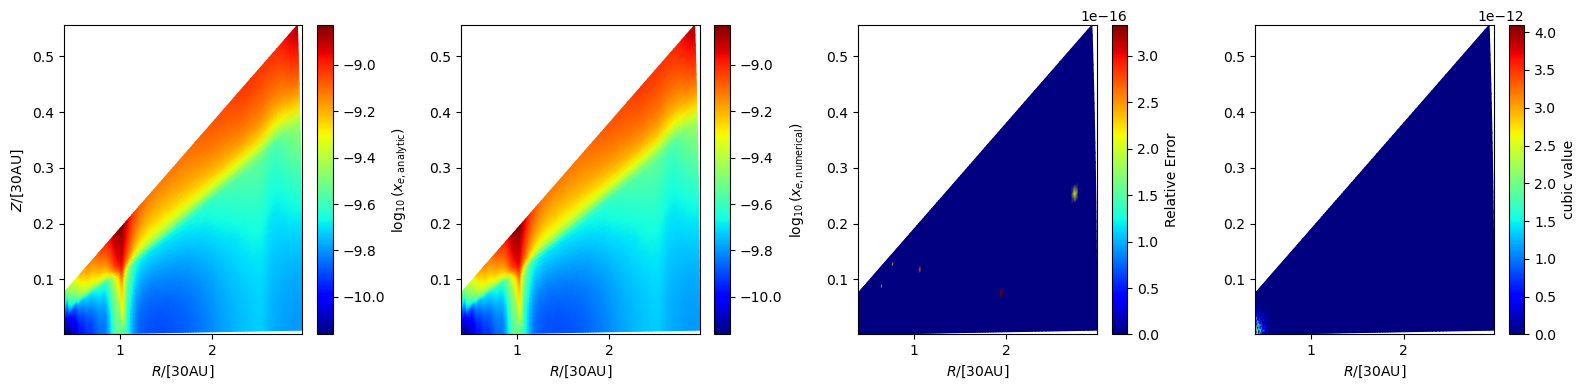

In [110]:
fig = plt.figure(figsize=(16,4))

fig.add_subplot(141)
im1 = plt.pcolormesh(Rcyl/(30*AU),Zcyl/(30*AU),np.log10(Xe_0),cmap='jet',shading='gouraud')
plt.xlabel(r"$R/[30{\rm AU}]$")
plt.ylabel(r"$Z/[30{\rm AU}]$")
plt.colorbar(im1, label=r'$\log_{10}(x_{e,{\rm analytic}})$')

fig.add_subplot(142)
im2 = plt.pcolormesh(Rcyl/(30*AU),Zcyl/(30*AU),np.log10(ne/nm),cmap='jet',shading='gouraud')
plt.xlabel(r"$R/[30{\rm AU}]$")
plt.colorbar(im2, label=r'$\log_{10}(x_{e,{\rm numerical}})$')

fig.add_subplot(143)
im3 = plt.pcolormesh(Rcyl/(30*AU),Zcyl/(30*AU),(np.abs((ne/nm)- Xe_0))/Xe,cmap='jet',shading='gouraud')
plt.xlabel(r"$R/[30{\rm AU}]$")
plt.colorbar(im3, label="Relative Error")

fig.add_subplot(144)
im4 = plt.pcolormesh(Rcyl/(30*AU),Zcyl/(30*AU),np.abs(cubic),cmap='jet',shading='gouraud')
plt.colorbar(im4, label="cubic value")
plt.xlabel(r"$R/[30{\rm AU}]$")

plt.tight_layout()
plt.show()

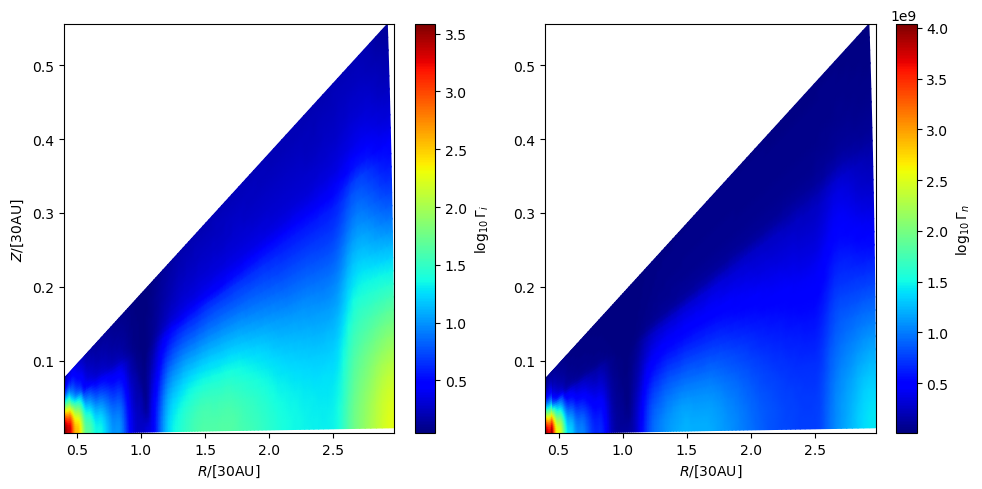

In [111]:
mn = 2.33 * mH
mnp = 1 * mH
mM = 30 * mH
mMp = 30 * mH
G = 6.674e-8 # dyn cm**2 g**-2
Mstar = 1.989e+33 # g
Omega = np.sqrt(G * Mstar / (Rcyl**3))
gamma_T = 3.5*1e+13 # cm**3 s**-1 g**-1

rho_m = nm * mn
rho_mp = nmp * mnp
rho_M = nM * mM
rho_Mp = nMp * mMp

rho_n = rho_m + rho_M
rho_i = rho_mp + rho_Mp

ions = gamma_T * rho_i / Omega
neutrals = gamma_T * rho_n / Omega

fig = plt.figure(figsize=(10,5))
fig.add_subplot(121)
im1 = plt.pcolormesh(Rcyl/(30*AU),Zcyl/(30*AU),ions,cmap='jet',shading='gouraud')
plt.xlabel(r"$R/[30{\rm AU}]$")
plt.ylabel(r"$Z/[30{\rm AU}]$")
plt.colorbar(im1, label=r"$\log_{10}{\Gamma_{i}}$")
fig.add_subplot(122)
im2 = plt.pcolormesh(Rcyl/(30*AU),Zcyl/(30*AU),neutrals,cmap='jet',shading='gouraud')
plt.xlabel(r"$R/[30{\rm AU}]$")
plt.colorbar(im2, label=r"$\log_{10}{\Gamma_{n}}$")

plt.tight_layout()
plt.show()

### $X_{M}=10^{-13}$

In [112]:
spath = "xM-13_gap"
snap_i = convergence(spath)

The solution converges at snap = 0.01 orbit(s)


In [113]:
ne  = np.load(f"{spath}/e_{snap_i:03}.npy")
nm  = np.load(f"{spath}/m_{snap_i:03}.npy")
nmp = np.load(f"{spath}/mp_{snap_i:03}.npy")
nM  = np.load(f"{spath}/M_{snap_i:03}.npy")
nMp = np.load(f"{spath}/Mp_{snap_i:03}.npy")

zeta = zeta_ion(Rcyl,Zcyl,rho)
cubic = cubic_func(ne,nM,nm,T,zeta)
Xe = Xe_func(nm,T,zeta)

# in principle the analitical value of Xe is calculated in the first snapshot as one root of the cubic, then...
ne_0 = np.load(f"{spath}/e_000.npy")
nm_0 = np.load(f"{spath}/m_000.npy")
Xe_0 = ne_0/nm_0

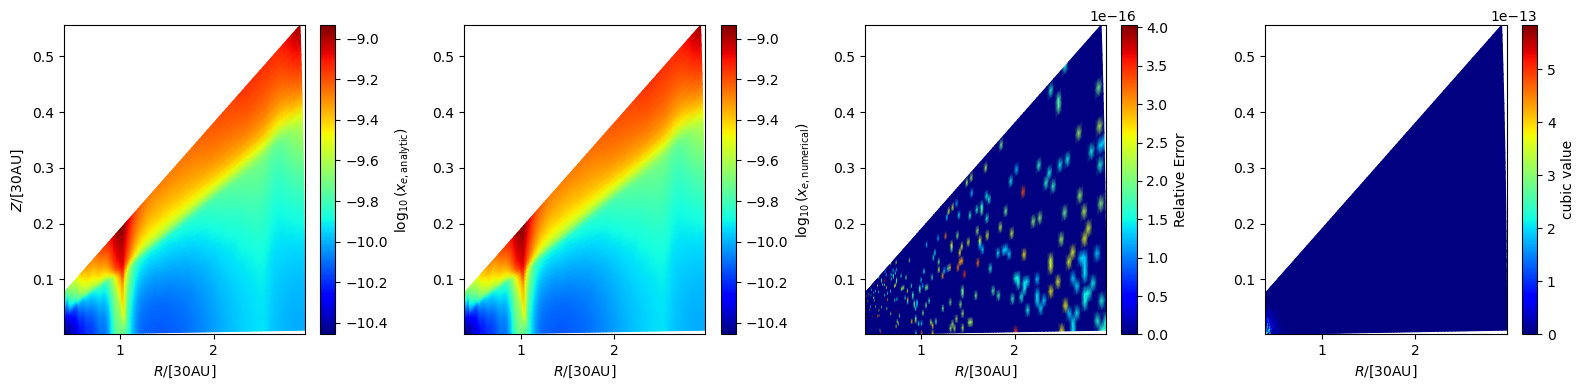

In [114]:
fig = plt.figure(figsize=(16,4))

fig.add_subplot(141)
im1 = plt.pcolormesh(Rcyl/(30*AU),Zcyl/(30*AU),np.log10(Xe_0),cmap='jet',shading='gouraud')
plt.xlabel(r"$R/[30{\rm AU}]$")
plt.ylabel(r"$Z/[30{\rm AU}]$")
plt.colorbar(im1, label=r'$\log_{10}(x_{e,{\rm analytic}})$')

fig.add_subplot(142)
im2 = plt.pcolormesh(Rcyl/(30*AU),Zcyl/(30*AU),np.log10(ne/nm),cmap='jet',shading='gouraud')
plt.xlabel(r"$R/[30{\rm AU}]$")
plt.colorbar(im2, label=r'$\log_{10}(x_{e,{\rm numerical}})$')

fig.add_subplot(143)
im3 = plt.pcolormesh(Rcyl/(30*AU),Zcyl/(30*AU),(np.abs((ne/nm)- Xe_0))/Xe,cmap='jet',shading='gouraud')
plt.xlabel(r"$R/[30{\rm AU}]$")
plt.colorbar(im3, label="Relative Error")

fig.add_subplot(144)
im4 = plt.pcolormesh(Rcyl/(30*AU),Zcyl/(30*AU),np.abs(cubic),cmap='jet',shading='gouraud')
plt.colorbar(im4, label="cubic value")
plt.xlabel(r"$R/[30{\rm AU}]$")

plt.tight_layout()
plt.show()

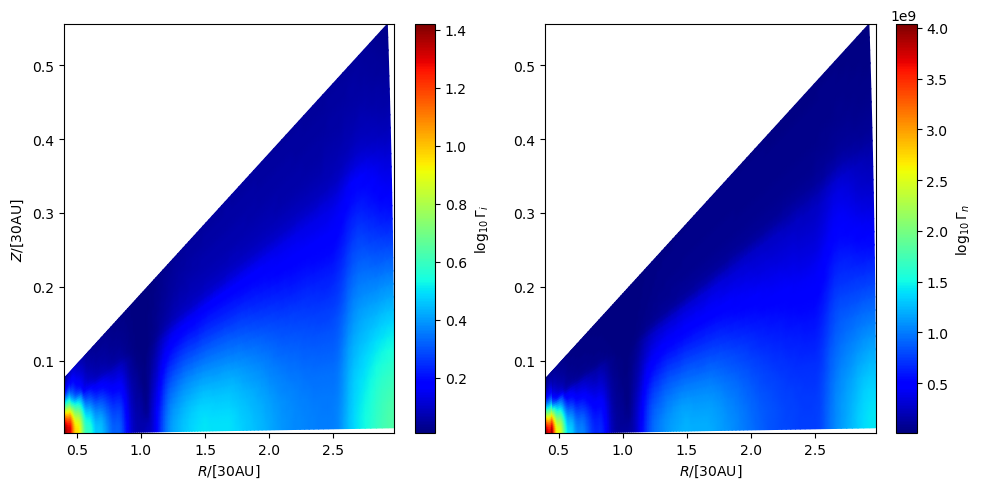

In [115]:
mn = 2.33 * mH
mnp = 1 * mH
mM = 30 * mH
mMp = 30 * mH
G = 6.674e-8 # dyn cm**2 g**-2
Mstar = 1.989e+33 # g
Omega = np.sqrt(G * Mstar / (Rcyl**3))
gamma_T = 3.5*1e+13 # cm**3 s**-1 g**-1

rho_m = nm * mn
rho_mp = nmp * mnp
rho_M = nM * mM
rho_Mp = nMp * mMp

rho_n = rho_m + rho_M
rho_i = rho_mp + rho_Mp

ions = gamma_T * rho_i / Omega
neutrals = gamma_T * rho_n / Omega

fig = plt.figure(figsize=(10,5))
fig.add_subplot(121)
im1 = plt.pcolormesh(Rcyl/(30*AU),Zcyl/(30*AU),ions,cmap='jet',shading='gouraud')
plt.xlabel(r"$R/[30{\rm AU}]$")
plt.ylabel(r"$Z/[30{\rm AU}]$")
plt.colorbar(im1, label=r"$\log_{10}{\Gamma_{i}}$")
fig.add_subplot(122)
im2 = plt.pcolormesh(Rcyl/(30*AU),Zcyl/(30*AU),neutrals,cmap='jet',shading='gouraud')
plt.xlabel(r"$R/[30{\rm AU}]$")
plt.colorbar(im2, label=r"$\log_{10}{\Gamma_{n}}$")

plt.tight_layout()
plt.show()